In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
# we use xgboost gradient boosting decsion trees model for this experiment 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

!pip install xgboost 
import xgboost as xgb

!pip install scikit-plot
import scikitplot as skplt

In [2]:
# model evaluation 
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from statistics import mean


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
# import the preprocessing functions we've made 
%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/'

import preprocess


%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity/'

/content/gdrive/Shared drives/PFE/Colab Notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity


In [5]:
# import the advertising dataset 
# Each ad has a binary label 0 for commercial and 1 for informational ads 
df= pd.read_csv('data/revised/training_scarcity_18k.csv') 

df=df.sample(frac=1)

In [6]:
df.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
df

,ad,scarcity
2363,only hours left this is a movement it’s not a...,1
8592,angie’s potential opponents are already attack...,1
3273,breaking daily kos ranks iowa is senate race a...,1
8558,uhn is emergency departments are the first lin...,1
7750,supporting the frontline heroes of this pandem...,1
...,...,...
11356,skoda jean lain automobiles appidfusefr,0
9450,amid the ongoing coronavirus pandemic we must ...,0
8011,it is time for yard signs fill out the form be...,1
8560,health emergency adding\nwe request receive fr...,1


In [7]:
import re 
# Functions for removing contractions 
contraction_dict = {"we're": "we are","ain't": "are not","'s":" is","aren't": "are not", "won't": "would not", "don't": "do not", "isn't": "is not", "it's" : "it is"}
def expand_contractions(data,contractions_dict = contraction_dict):
  '''
    Expanding Contractions
    Arguments:
      data: textual dataset 
      contractions_dict : dictionanary containing the contractions and their replacements 
    Returns :
      clean_data : textual dataset where contractions are expanded
  '''
  # Regular expression for finding contractions
  contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
  def replace(match):
      return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, data)

In [8]:
import string 

df['ad'] = df['ad'].str.strip().str.lower() 

# Expand contractions 
df['ad'] = df['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df['ad'] =  df['ad'].str.translate(str.maketrans('','',string.punctuation))

df

,ad,scarcity
2363,only hours left this is a movement it’s not a...,1
8592,angie’s potential opponents are already attack...,1
3273,breaking daily kos ranks iowa is senate race a...,1
8558,uhn is emergency departments are the first lin...,1
7750,supporting the frontline heroes of this pandem...,1
...,...,...
11356,skoda jean lain automobiles appidfusefr,0
9450,amid the ongoing coronavirus pandemic we must ...,0
8011,it is time for yard signs fill out the form be...,1
8560,health emergency adding\nwe request receive fr...,1


In [9]:
# vectorize testing and training data 
train_data, test_data = preprocess.eval_train_split(df['ad'], df['scarcity'] , test_size = 0.2, validation = False)
X_train, y_train, X_test, y_test = train_data[0], train_data[1], test_data[0], test_data[1]

tf_vectorizer = CountVectorizer() 

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [10]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train_tf, y_train)

XGBClassifier()

accuracy:   0.932
              precision    recall  f1-score   support

 no-scarcity       0.90      0.97      0.93      1775
    scarcity       0.97      0.90      0.93      1825

    accuracy                           0.93      3600
   macro avg       0.93      0.93      0.93      3600
weighted avg       0.93      0.93      0.93      3600

confusion matrix:
[[1720   55]
 [ 189 1636]]



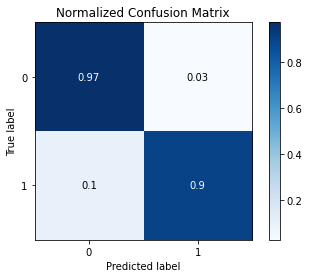

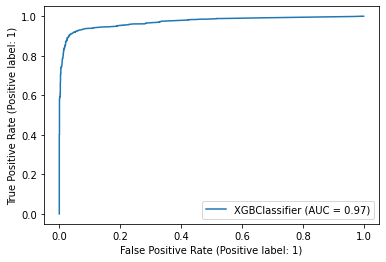

In [11]:
# predict the labels on validation dataset
predictions = xgb_clf.predict(X_test_tf)

# compute the performance measures
score1 = metrics.accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_test, predictions, target_names=['no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
svc_disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_test_tf, y_test)

In [12]:
import re
import string
df_val = pd.read_csv('data/revised/test_scarcity_4k.csv')

df_val

,Unnamed: 0,ad,scarcity
0,2536,don’t miss your last chance this year to help ...,1
1,5208,ive been taking the fight to darrell issa ever...,1
2,7505,partisan politics special interests career pol...,1
3,4037,michigan voters just elected an abortion right...,1
4,5629,it is time to hit the streets again with team ...,1
...,...,...,...
4975,10171,what does sustainable policy for climate chang...,0
4976,15036,kris kobach is responsible for the worst voter...,0
4977,16023,dc playbook alert the people of wyoming deserv...,0
4978,5102,if you were a victim of clergy sexual abuse yo...,0


accuracy:   0.930
              precision    recall  f1-score   support

 no-scarcity       0.90      0.96      0.93      2490
    scarcity       0.96      0.90      0.93      2490

    accuracy                           0.93      4980
   macro avg       0.93      0.93      0.93      4980
weighted avg       0.93      0.93      0.93      4980

confusion matrix:
[[2392   98]
 [ 252 2238]]



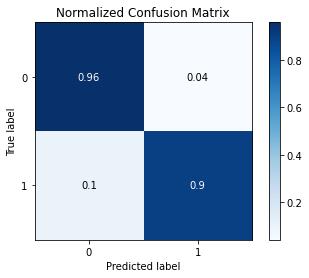

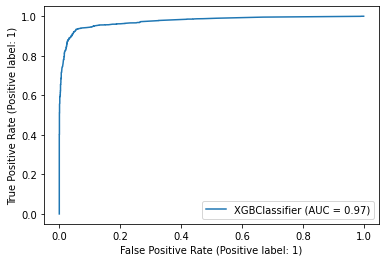

In [13]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['scarcity']

y_pred = xgb_clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_val, y_val)

In [14]:
df_val = pd.read_csv('data/sample_130.csv')
df_val.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
df_val=df_val.sample(frac=1)


df_val['ad'] = df_val['ad'].str.strip().str.lower() 

# Expand contractions 
df_val['ad'] = df_val['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df_val['ad'] =  df_val['ad'].str.translate(str.maketrans('','',string.punctuation))

df_val




X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['scarcity']

accuracy:   0.563
              precision    recall  f1-score   support

 no-scarcity       0.53      0.64      0.58        59
    scarcity       0.61      0.49      0.55        67

    accuracy                           0.56       126
   macro avg       0.57      0.57      0.56       126
weighted avg       0.57      0.56      0.56       126

confusion matrix:
[[38 21]
 [34 33]]



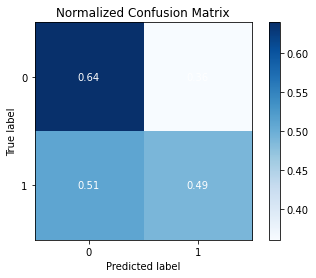

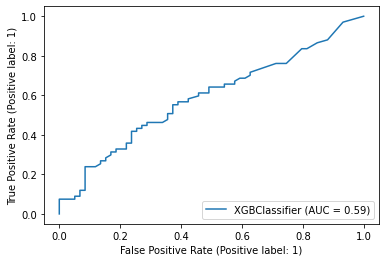

In [15]:
y_pred = xgb_clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_val, y_val)

In [ ]:
df_val['predictions']=y_pred
df_val.to_csv("verifications_boost.csv")